In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "covid_data",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 7242 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
print(class_names)

['COVID', 'Normal']


In [6]:
len(dataset)

227

In [7]:
train_s = 0.8
train_s*len(dataset)

181.60000000000002

In [8]:
val_s = 0.1
val_s*len(dataset)

22.700000000000003

In [9]:
test_s = 0.1
test_s*len(dataset)

22.700000000000003

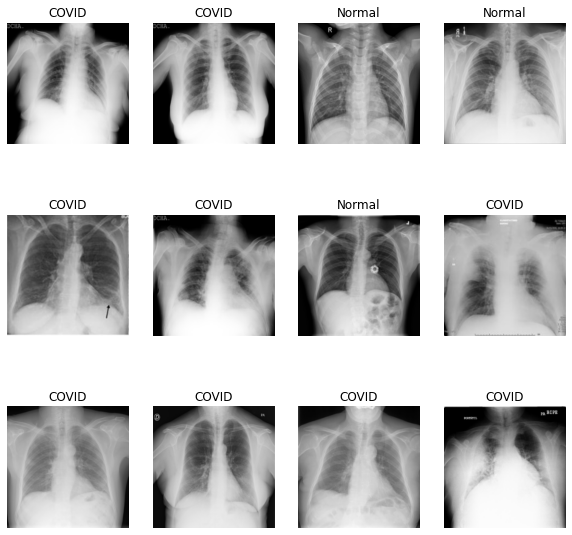

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [11]:
def split_dataset(ds, train_sp=0.8, val_sp=0.1, test_sp=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
         
    train_size = int(train_sp * ds_size)
    val_size = int(val_sp * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [12]:

train_ds, val_ds, test_ds = split_dataset(dataset)

In [13]:
len(train_ds)

181

In [14]:
len(val_ds)

22

In [15]:
len( test_ds)

24

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
    
])

In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [21]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [22]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/50
181/181 [==============================] - 1320s 6s/step - loss: 0.6747 - accuracy: 0.5554 - val_loss: 0.6531 - val_accuracy: 0.6179
Epoch 2/50
181/181 [==============================] - 1125s 4s/step - loss: 0.5914 - accuracy: 0.6837 - val_loss: 0.6118 - val_accuracy: 0.6861
Epoch 3/50
181/181 [==============================] - 1228s 5s/step - loss: 0.5512 - accuracy: 0.7277 - val_loss: 0.5323 - val_accuracy: 0.7202
Epoch 4/50
181/181 [==============================] - 1051s 5s/step - loss: 0.5196 - accuracy: 0.7506 - val_loss: 0.5252 - val_accuracy: 0.7287
Epoch 5/50
181/181 [==============================] - 1172s 5s/step - loss: 0.5067 - accuracy: 0.7538 - val_loss: 0.4910 - val_accuracy: 0.7514
Epoch 6/50
181/181 [==============================] - 1387s 5s/step - loss: 0.4971 - accuracy: 0.7615 - val_loss: 0.4736 - val_accuracy: 0.7543
Epoch 7/50
181/181 [==============================] - 1120s 5s/step - loss: 0.4831 - accuracy: 0.7652 - val_loss: 0.5161 - val_accuracy:

In [23]:
scores = model.evaluate(test_ds)

24/24 [==============================] - 378s 2s/step - loss: 0.1365 - accuracy: 0.9479


first image to predict
actual label to predict: COVID
predicted label : COVID


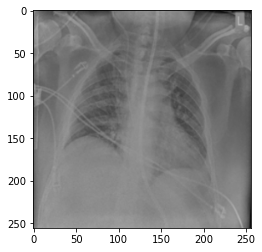

In [24]:
for images_batch, lables_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = lables_batch[0].numpy()
    print('first image to predict')
    plt.imshow(first_image)
    print('actual label to predict:', class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print('predicted label :', class_names[np.argmax(batch_prediction[0])])


In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

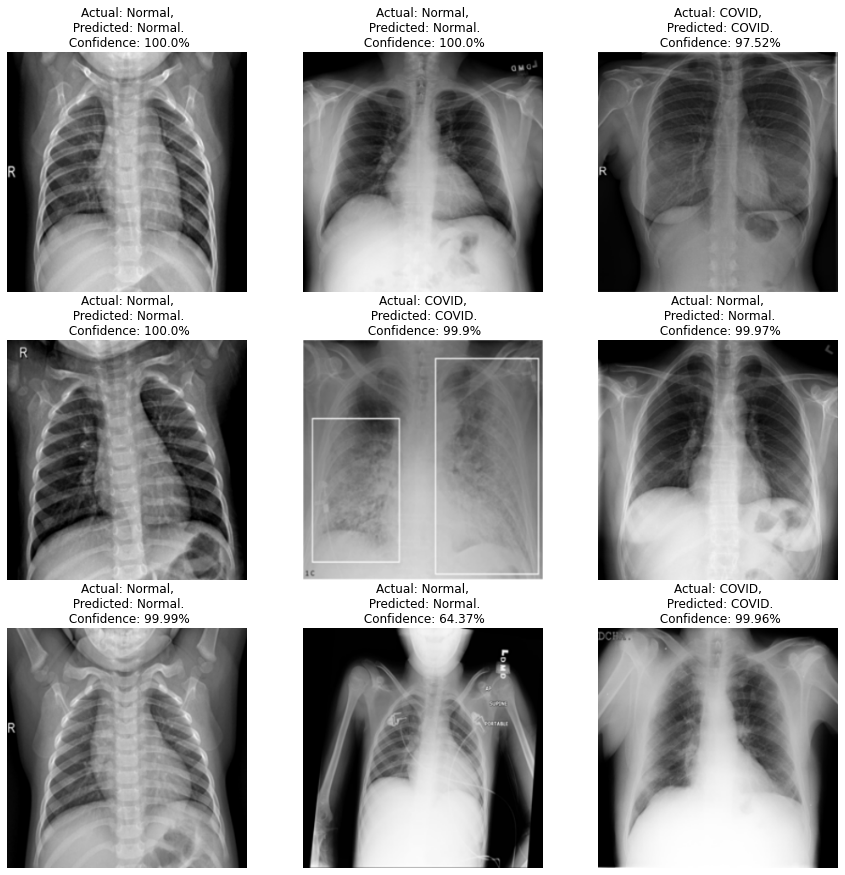

In [26]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [27]:
model_version = 3
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/3\assets


In [28]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/5\assets


In [29]:
from tensorflow.keras.models import Sequential, save_model

In [33]:
filepath = '../saved_model'
save_model(model, filepath)

INFO:tensorflow:Assets written to: ../saved_model\assets


In [34]:
tf.keras.models.save_model(
    model,
    filepath,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

INFO:tensorflow:Assets written to: ../saved_model\assets


In [35]:
filepath = './saved_models2'
save_model(model, filepath, save_format='h5')

In [36]:
from tensorflow.keras.models import Sequential, save_model, load_model

In [37]:
import numpy as np

In [38]:
# Load the model
loaded_model = load_model(
    filepath,
    custom_objects=None,
    compile=True
)

In [40]:

# saving and loading the .h5 model
 
# save model
model.save('gfgModel.h5')
print('Model Saved!')
 
# load model
savedModel=load_model('gfgModel.h5')
savedModel.summary()

Model Saved!
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 3

In [41]:

# saving and loading the model weights
 
# save model
model.save_weights('gfgModelWeights')
print('Model Saved!')
 
# load model
savedModel = model.load_weights('gfgModelWeights')
print('Model Loaded!')

Model Saved!
Model Loaded!


In [42]:
model.save("../covid.h5")